In [37]:
import pandas as pd

df = pd.read_csv('/data/Data/PD/res_site_complete_2.csv')
df

,participant_id,Subject,Study,Extension,Root,Path,Path_jac,Path_harm,Site,Site.1,Age,Sex,Group,Type,Vendor,FS,Age_bin
0,sub-001,3000,PPMI_10,.nii.gz,../affine_using_nifty_reg_harm/,../affine_using_nifty_reg/3000.nii.gz,../jacobians_using_nifty_reg/3000.nii.gz,../affine_using_nifty_reg_harm/3000.nii.gz,12,11,69.0,F,HC,GE Signa Hdxt,GE,3.0,1
1,sub-002,3001,PPMI_10,.nii.gz,../affine_using_nifty_reg_harm/,../affine_using_nifty_reg/3001.nii.gz,../jacobians_using_nifty_reg/3001.nii.gz,../affine_using_nifty_reg_harm/3001.nii.gz,12,11,65.0,M,PD,GE Signa Hdxt,GE,3.0,1
2,sub-003,3002,PPMI_10,.nii.gz,../affine_using_nifty_reg_harm/,../affine_using_nifty_reg/3002.nii.gz,../jacobians_using_nifty_reg/3002.nii.gz,../affine_using_nifty_reg_harm/3002.nii.gz,12,11,68.0,F,PD,GE Signa Hdxt,GE,3.0,1
3,sub-004,3003,PPMI_10,.nii.gz,../affine_using_nifty_reg_harm/,../affine_using_nifty_reg/3003.nii.gz,../jacobians_using_nifty_reg/3003.nii.gz,../affine_using_nifty_reg_harm/3003.nii.gz,12,11,57.0,F,PD,GE Signa Hdxt,GE,3.0,0
4,sub-005,3004,PPMI_10,.nii.gz,../affine_using_nifty_reg_harm/,../affine_using_nifty_reg/3004.nii.gz,../jacobians_using_nifty_reg/3004.nii.gz,../affine_using_nifty_reg_harm/3004.nii.gz,12,11,59.0,M,HC,GE Signa Hdxt,GE,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1875,sub-1546,UOA9033,UOA,.nii.gz,../affine_using_nifty_reg_harm/,../affine_using_nifty_reg/UOA9033.nii.gz,../jacobians_using_nifty_reg/UOA9033.nii.gz,../affine_using_nifty_reg_harm/UOA9033.nii.gz,41,40,72.0,F,PD,Siemens Prisma,Siemens,3.0,1
1876,sub-1547,UOA9104,UOA,.nii.gz,../affine_using_nifty_reg_harm/,../affine_using_nifty_reg/UOA9104.nii.gz,../jacobians_using_nifty_reg/UOA9104.nii.gz,../affine_using_nifty_reg_harm/UOA9104.nii.gz,41,40,67.1,M,PD,Siemens Prisma,Siemens,3.0,1
1877,sub-1548,UOA9597,UOA,.nii.gz,../affine_using_nifty_reg_harm/,../affine_using_nifty_reg/UOA9597.nii.gz,../jacobians_using_nifty_reg/UOA9597.nii.gz,../affine_using_nifty_reg_harm/UOA9597.nii.gz,41,40,73.1,F,PD,Siemens Prisma,Siemens,3.0,1
1878,sub-1549,UOA9648,UOA,.nii.gz,../affine_using_nifty_reg_harm/,../affine_using_nifty_reg/UOA9648.nii.gz,../jacobians_using_nifty_reg/UOA9648.nii.gz,../affine_using_nifty_reg_harm/UOA9648.nii.gz,41,40,69.3,F,PD,Siemens Prisma,Siemens,3.0,1


In [38]:
def drop_study(df, sites):
    mask = ~df['Study'].str.contains('|'.join(sites), case=True, na=False)
    df = df[mask]
    df.reset_index(drop=True, inplace=True)
    return df

In [39]:
df = drop_study(df, ['PPMI', 'HMC', 'JGH', 'RUH', 'SBK', 'MUC'])

In [81]:

import numpy as np


def visualize(df, bias_var):
    count_df = df.groupby([bias_var, 'Group']).size().unstack(fill_value=0)

    # Create figure
    fig, ax = plt.subplots(figsize=(15, 6))

    # Create stacked bar plot
    colors = sns.color_palette("husl", n_colors=len(count_df.columns))
    bottom = np.zeros(len(count_df.index))

    for i, (colname, color) in enumerate(zip(count_df.columns, colors)):
        values = count_df[colname]
        ax.bar(count_df.index, values, bottom=bottom, label=colname, color=color)
        # Add count labels in the middle of each segment
        for j, v in enumerate(values):
            if v > 0:  # Only add label if there's a value
                ax.text(j, bottom[j] + v / 2, str(int(v)),
                        ha='center', va='center',
                        fontweight='bold', color='white')
        bottom += values

    # Customize the plot
    ax.set_title(f'Count Distribution by {bias_var} and PD', pad=15)
    ax.set_xlabel(f'{bias_var}')
    ax.set_ylabel('Count')

    wrapped_labels = ['\n'.join(wrap(label.get_text(), width=7)) for label in ax.get_xticklabels()]
    ax.set_xticks(np.arange(len(wrapped_labels)))
    ax.set_xticklabels(wrapped_labels)

    # Add legend
    ax.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add total counts on top of each stack
    for i, total in enumerate(bottom):
        ax.text(i, total, f'{int(total)}',
                ha='center', va='bottom',
                fontweight='bold')

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

    return fig

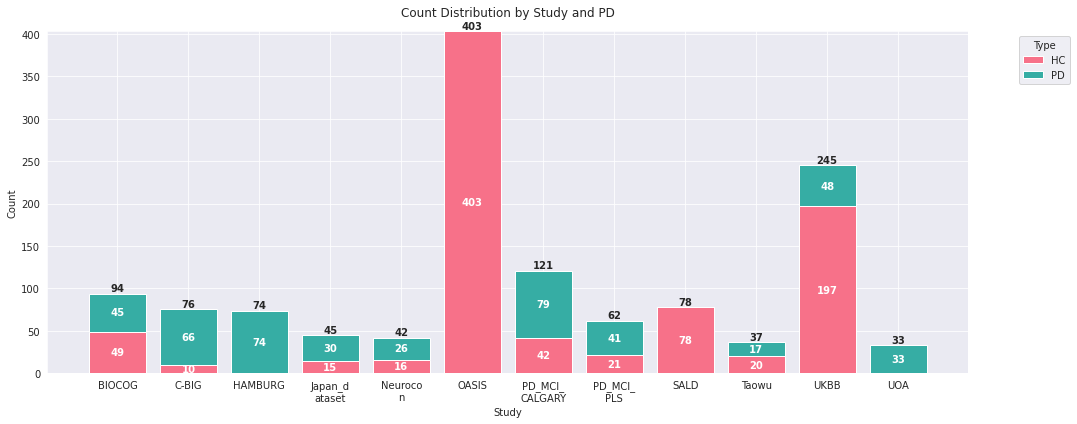

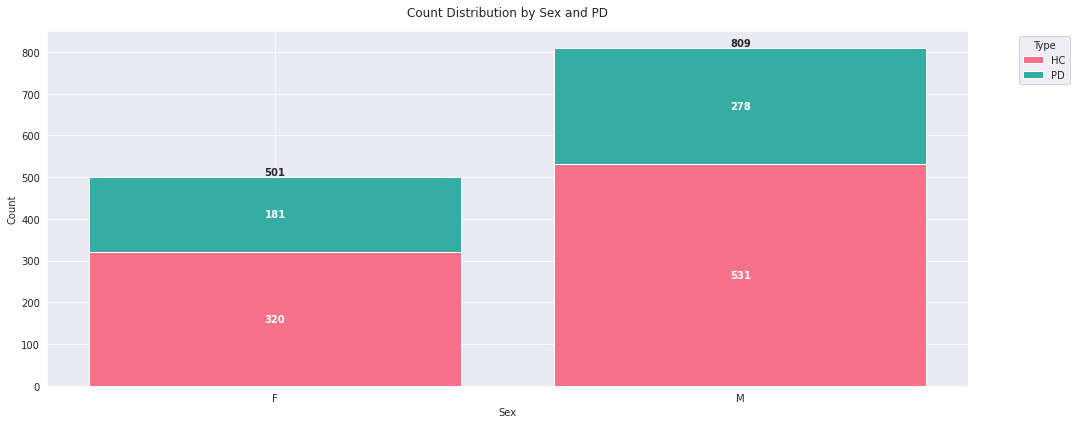

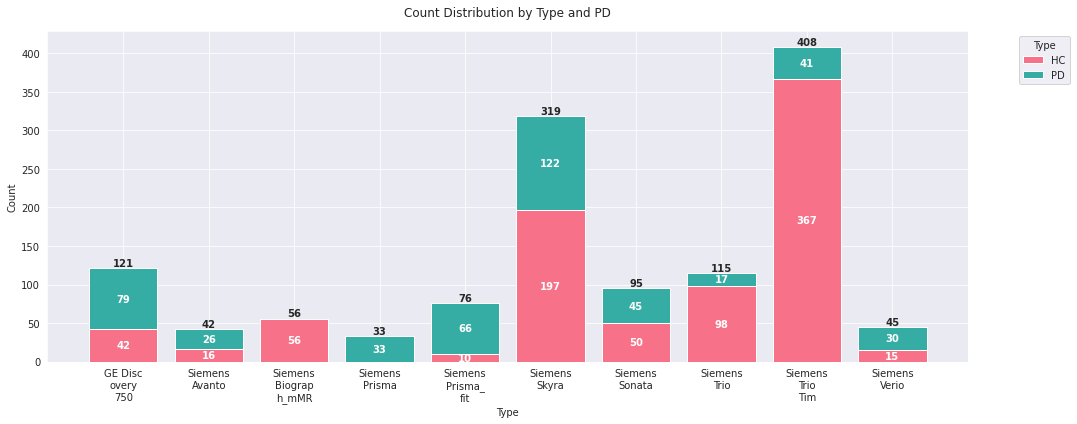

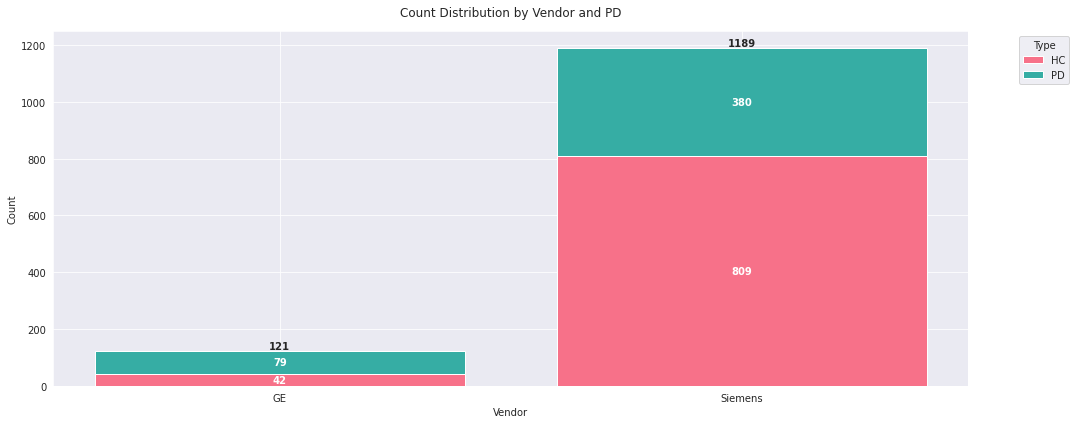

In [80]:
cols = ['Study', 'Sex', 'Type', 'Vendor']
for c in cols:
    visualize(df, c).savefig(f'/data/Papers/MICCAI-biases/data/{c}.pdf')

In [88]:
def categorize(df, col):
    type_unique = df[col].unique()
    type_categories = {k: v for k, v in zip(type_unique, np.arange(len(type_unique)))}
    print(type_categories)
    df[col] = df[col].map(type_categories)
    return df, type_categories


def binarize(df, col, val):
    df[col] = (df[col] == val).astype('int')
    return df

In [89]:
df, scanner_dict = categorize(df, 'Type')
df, vendor_dict = categorize(df, 'Vendor')
df, study_dict = categorize(df, 'Study')
df = binarize(df, 'Sex', 'M')
df = binarize(df, 'Group', 'PD')

{'Siemens Skyra': 0, 'Siemens Sonata': 1, 'Siemens Avanto': 2, 'Siemens Trio': 3, 'Siemens Verio': 4, 'Siemens Trio Tim': 5, 'Siemens Biograph_mMR': 6, 'GE Discovery 750': 7, 'Siemens Prisma_fit': 8, 'Siemens Prisma': 9}
{'Siemens': 0, 'GE': 1}
{'UKBB': 0, 'BIOCOG': 1, 'Neurocon': 2, 'Taowu': 3, 'Japan_dataset': 4, 'PD_MCI_PLS': 5, 'OASIS': 6, 'HAMBURG': 7, 'PD_MCI_CALGARY': 8, 'SALD': 9, 'C-BIG': 10, 'UOA': 11}


<ipython-input-88-b012eb3b9387>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].map(type_categories)
<ipython-input-88-b012eb3b9387>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].map(type_categories)
<ipython-input-88-b012eb3b9387>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [94]:
grouped_df = df.groupby('Sex')['Sex'].value_counts()
percentages = (grouped_df / grouped_df.sum() * 100).to_list()
percentages

[38.2442748091603, 61.7557251908397]

In [29]:
from sklearn.model_selection import train_test_split


def stratified_data_split(df, target_column, train_size=0.6, val_size=0.2, test_size=0.2, random_state=42):
    train_val, test = train_test_split(df, test_size=test_size, stratify=df[target_column], random_state=random_state)
    train, val = train_test_split(train_val, test_size=val_size / (train_size + val_size),
                                  stratify=train_val[target_column], random_state=random_state)
    return train, val, test

In [30]:
train, val, test = stratified_data_split(df, 'Group')

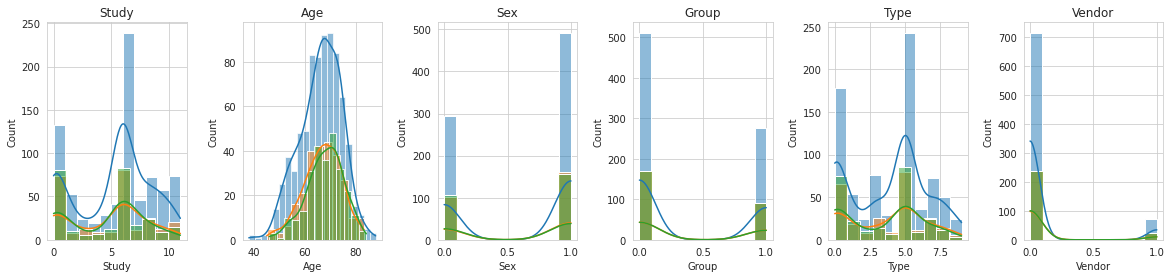

In [31]:
visualize_data([train, test, val], cols)

In [32]:
train.to_csv('/data/Data/PD/train.csv', index=False)
test.to_csv('/data/Data/PD/test.csv', index=False)
val.to_csv('/data/Data/PD/val.csv', index=False)